In [1]:
require(data.table)
require(caret)

Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.6.2"Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"

Start with reading train data with features created.

In [2]:
train = fread("train_feature.csv", encoding = "UTF-8")

In [3]:
str(train)

Classes 'data.table' and 'data.frame':	5618 obs. of  32 variables:
 $ unique_id                       : int  1 2 3 4 5 6 7 8 10 11 ...
 $ gender                          : chr  "F" "F" "F" "F" ...
 $ brand_gender                    : chr  "Kadin" "Kadin" "Kadin" "Kadin" ...
 $ cat_gender                      : chr  "Unisex" "Unisex" "Kadin" "Kadin" ...
 $ fav_product_gender              : chr  "Unisex" "Kadin" "Kadin" "Kadin" ...
 $ wDay_basket                     : chr  "weekday" "weekday" "weekend" "weekday" ...
 $ wDay_favorite                   : chr  "weekday" "weekday" "Unknown" "weekday" ...
 $ wDay_order                      : chr  "weekday" "weekday" "weekend" "weekday" ...
 $ wDay_search                     : chr  "weekend" "weekend" "weekend" "weekday" ...
 $ wDay_visit                      : chr  "weekday" "weekday" "weekday" "weekday" ...
 $ daytime_basket                  : chr  "night" "evening" "night" "afternoon" ...
 $ daytime_favorite                : chr  "night" "a

Convert character values to factor so that we can use them as predictors.

In [4]:
cols = c("unique_id", "gender", 'brand_gender', 'cat_gender', 'fav_product_gender', 'wDay_basket',
         'wDay_favorite', 'wDay_order', 'wDay_search', 'wDay_visit', 'daytime_basket',
         'daytime_favorite', 'daytime_order', 'daytime_search', 'daytime_visit')
train[,(cols):=lapply(.SD, as.factor),.SDcols=cols]

## Scaling
Create a version of train data with scaling and centering numerical columns of training data to see if we can have improvement using scaling. 

In [5]:
preProcValues <- preProcess(train, method = c("center", "scale"))
preProcValues

Created from 5618 samples and 32 variables

Pre-processing:
  - centered (17)
  - ignored (15)
  - scaled (17)


In [6]:
train_scaled <- predict(preProcValues, train)

## Metric Calcualtion Function
We created a function calculating the performance metric mentioned in project description, average of AUC and BAR. We used perfo value from the result of the function to compare different models. 

In [7]:
performance<- function(data, lev, model){
    two_class <- twoClassSummary(data, lev, model)
    perfo = two_class["Sens"]*0.25 + two_class["Spec"]*0.25 + two_class["ROC"]*0.5
    names(perfo) = "perfo"
    combined = c(two_class, perfo)
    combined
}

## CART
Classification and regression tree runs and results using train data and scaled train data.

In [8]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
cart_grid = expand.grid(cp=c(0:20)*0.00025)
set.seed(1)
cart_fit=train(gender ~ ., 
               data = train[, -c("unique_id")],
               method = "rpart", 
               trControl = fitControl, 
               metric = "perfo",
               tuneGrid = cart_grid)

In [127]:
cart_fit

CART 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  cp       ROC        Sens       Spec       perfo    
  0.00000  0.8019384  0.7659710  0.6741536  0.7610004
  0.00025  0.8038880  0.7638504  0.6914818  0.7657771
  0.00050  0.8081701  0.7578157  0.7289221  0.7757695
  0.00075  0.8145458  0.7497711  0.7621361  0.7852497
  0.00100  0.8199531  0.7428650  0.7886523  0.7928559
  0.00125  0.8252873  0.7377007  0.8045372  0.7982031
  0.00150  0.8266386  0.7353096  0.8118605  0.8001118
  0.00175  0.8285999  0.7324260  0.8192794  0.8022263
  0.00200  0.8290963  0.7292187  0.8218567  0.8023170
  0.00225  0.8289110  0.7259033  0.8277426  0.8028670
  0.00250  0.8277447  0.7210122  0.8325885  0.8022725
  0.00275  0.8254938  0.7200856  0.8314545  0.8006319
  0.00300  0.

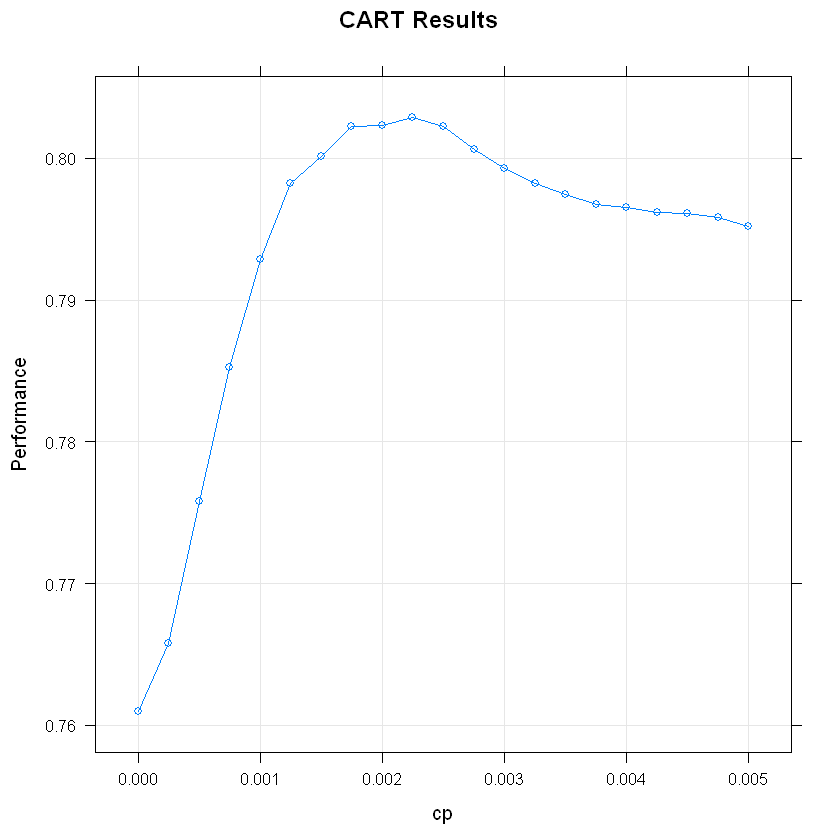

In [30]:
plot(cart_fit, xlab="cp", ylab="Performance", main="CART Results")

Best result is obtained with cp = 0.00225  

In [11]:
set.seed(1)
cart_fit_scaled=train(
    gender ~ ., 
    data = train_scaled[, -c("unique_id")],
    method = "rpart", 
    trControl = fitControl, 
    metric = "perfo",
    tuneGrid = cart_grid)

In [12]:
cart_fit_scaled

CART 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  cp       ROC        Sens       Spec       perfo    
  0.00000  0.8019103  0.7658078  0.6743603  0.7609972
  0.00025  0.8038470  0.7636872  0.6916885  0.7657674
  0.00050  0.8081227  0.7576525  0.7290257  0.7757309
  0.00075  0.8145450  0.7496079  0.7622397  0.7852344
  0.00100  0.8198940  0.7426475  0.7887559  0.7927979
  0.00125  0.8252912  0.7375920  0.8045372  0.7981779
  0.00150  0.8266307  0.7352010  0.8118605  0.8000807
  0.00175  0.8285913  0.7323173  0.8192794  0.8021948
  0.00200  0.8290860  0.7291100  0.8218567  0.8022847
  0.00225  0.8289155  0.7258490  0.8277426  0.8028557
  0.00250  0.8277625  0.7209578  0.8326922  0.8022938
  0.00275  0.8255116  0.7200312  0.8315581  0.8006532
  0.00300  0.

Scaled train data did not change the results very much.

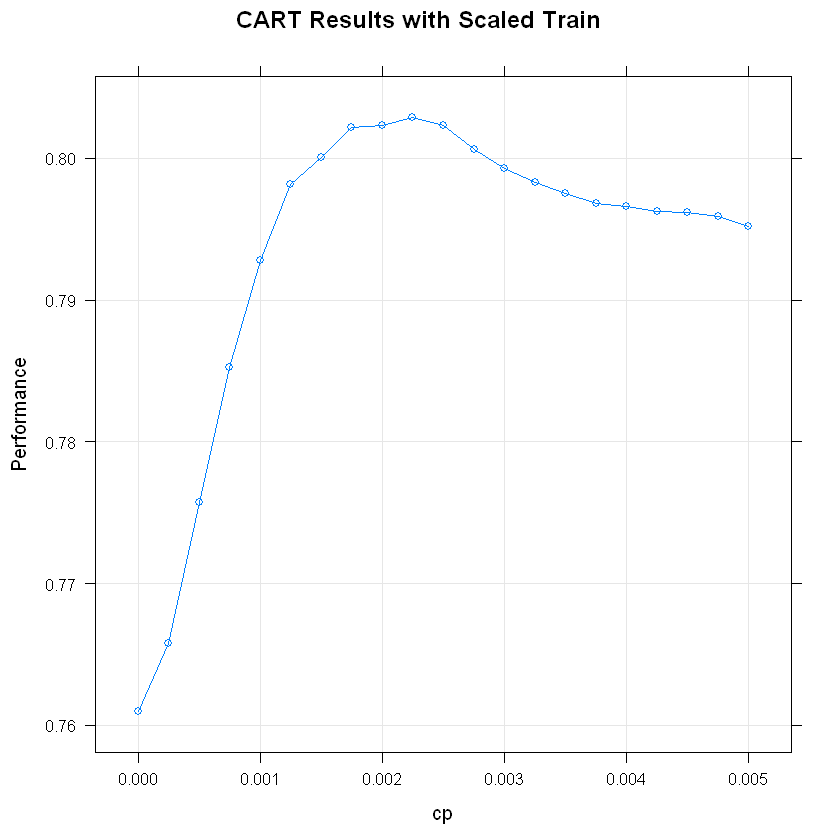

In [31]:
plot(cart_fit_scaled, xlab="cp", ylab="Performance", main="CART Results with Scaled Train")

## Lasso Regression
Lasso regression runs and results

In [14]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
lasso_grid = expand.grid(alpha=1, lambda=c(1:50)*0.0001)
set.seed(1)
lasso_fit=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "glmnet",
              trControl = fitControl,
              metric = "perfo",
              tuneGrid = lasso_grid)

In [15]:
lasso_fit

glmnet 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  lambda  ROC        Sens       Spec       perfo    
  0.0001  0.8269941  0.6573528  0.8568218  0.7920407
  0.0002  0.8269145  0.6565368  0.8577496  0.7920289
  0.0003  0.8268083  0.6555038  0.8587805  0.7919752
  0.0004  0.8266653  0.6543620  0.8596063  0.7918247
  0.0005  0.8265144  0.6532752  0.8602254  0.7916324
  0.0006  0.8263832  0.6525129  0.8606373  0.7914791
  0.0007  0.8262671  0.6513171  0.8615672  0.7913546
  0.0008  0.8261014  0.6505555  0.8624961  0.7913136
  0.0009  0.8259941  0.6497403  0.8635281  0.7913141
  0.0010  0.8258794  0.6485442  0.8640436  0.7910866
  0.0011  0.8257563  0.6478920  0.8648683  0.7910682
  0.0012  0.8256108  0.6462066  0.8655900  0.7907546
  0.0013  0.8254421  0.6

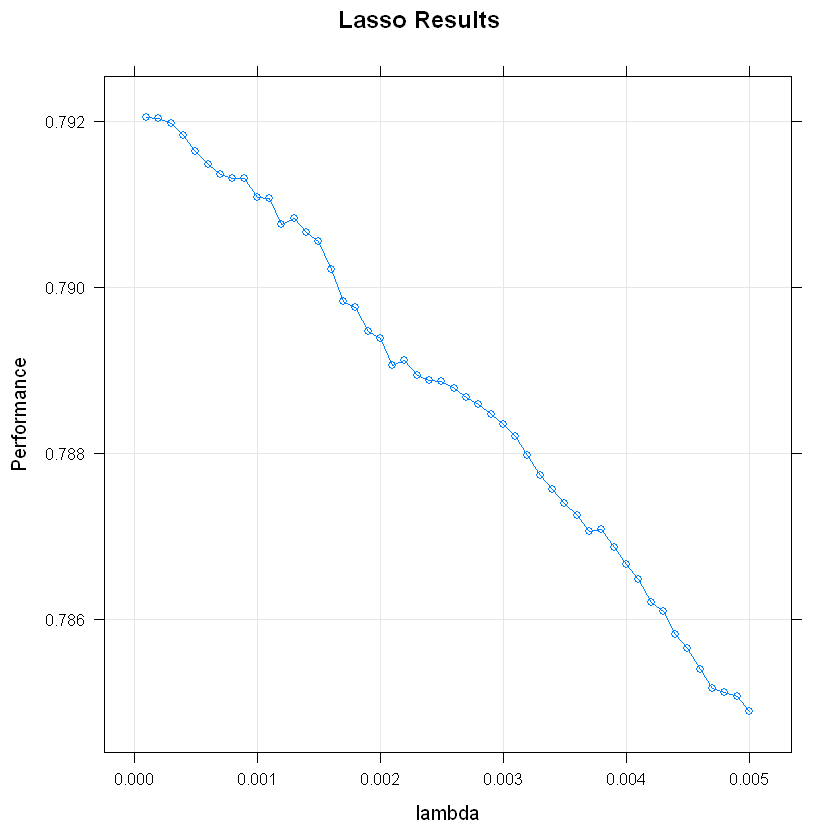

In [32]:
plot(lasso_fit, xlab="lambda", ylab="Performance", main="Lasso Results")

Best result is obtained with the smallest value of lambda, 0.0001. Smallest lambda may mean that the model does not intend to remove features.

In [17]:
n_repeats=5
n_folds=10
set.seed(1)
lasso_fit_scaled=train(gender ~ ., 
              data = train_scaled[, -c("unique_id")],
              method = "glmnet",
              trControl = fitControl,
              metric = "perfo",
              tuneGrid = lasso_grid)

In [18]:
lasso_fit_scaled

glmnet 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  lambda  ROC        Sens       Spec       perfo    
  0.0001  0.8269941  0.6573528  0.8568218  0.7920407
  0.0002  0.8269145  0.6565368  0.8577496  0.7920289
  0.0003  0.8268083  0.6555038  0.8587805  0.7919752
  0.0004  0.8266653  0.6543620  0.8596063  0.7918247
  0.0005  0.8265144  0.6532752  0.8602254  0.7916324
  0.0006  0.8263832  0.6525129  0.8606373  0.7914791
  0.0007  0.8262671  0.6513171  0.8615672  0.7913546
  0.0008  0.8261014  0.6505555  0.8624961  0.7913136
  0.0009  0.8259941  0.6497403  0.8635281  0.7913141
  0.0010  0.8258794  0.6485442  0.8640436  0.7910866
  0.0011  0.8257563  0.6478920  0.8648683  0.7910682
  0.0012  0.8256108  0.6462066  0.8655900  0.7907546
  0.0013  0.8254421  0.6

Scaled train did not improve the results, noticeably.

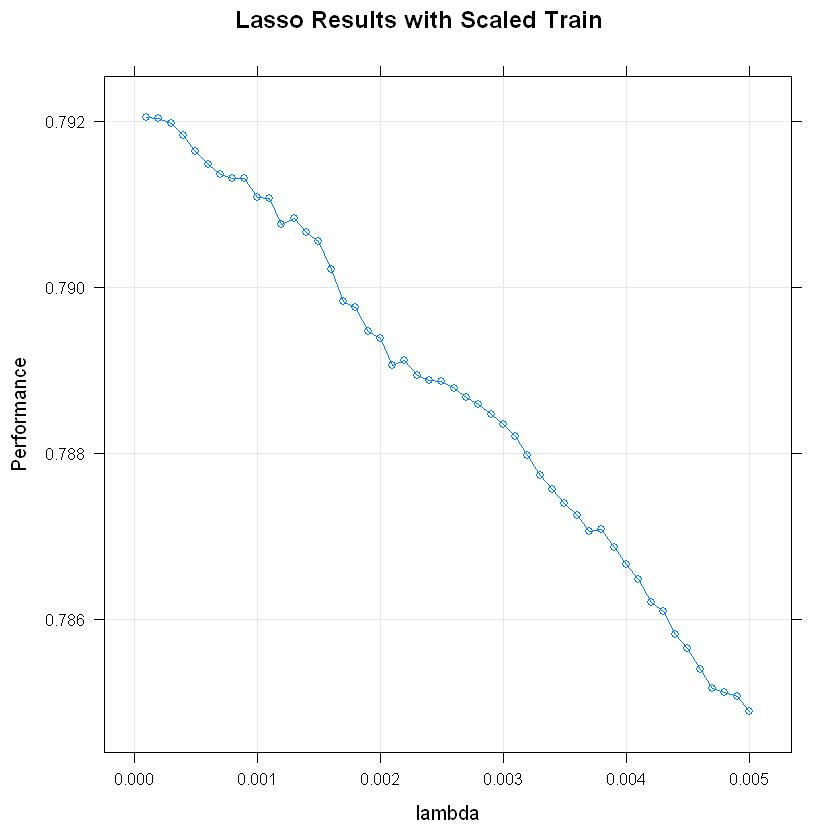

In [33]:
plot(lasso_fit_scaled, xlab="lambda", ylab="Performance", main="Lasso Results with Scaled Train")

## Elastic Net
ElasticNet Regression runs and results

In [22]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
elas_grid = expand.grid(alpha = c(0.1, 0.25, 0.5, 0.75), lambda = c(0.001, 0.005, 0.01, 0.05))
set.seed(1)
elas_fit=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "glmnet",
              trControl = fitControl,
              metric = "perfo",
              tuneGrid = elas_grid)

In [23]:
elas_fit

glmnet 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  alpha  lambda  ROC        Sens       Spec       perfo    
  0.10   0.001   0.8237750  0.6511532  0.8569291  0.7889081
  0.10   0.005   0.8175357  0.6422931  0.8579616  0.7838315
  0.10   0.010   0.8137329  0.6358780  0.8617755  0.7812798
  0.10   0.050   0.8027558  0.5985859  0.8771438  0.7703103
  0.25   0.001   0.8237099  0.6514258  0.8566172  0.7888657
  0.25   0.005   0.8176419  0.6393567  0.8610518  0.7839231
  0.25   0.010   0.8135037  0.6279409  0.8679627  0.7807278
  0.25   0.050   0.8009481  0.5790164  0.8864291  0.7668354
  0.50   0.001   0.8247933  0.6502836  0.8618765  0.7904366
  0.50   0.005   0.8182174  0.6322894  0.8717777  0.7851255
  0.50   0.010   0.8138632  0.6152750  0.8809615  0.7

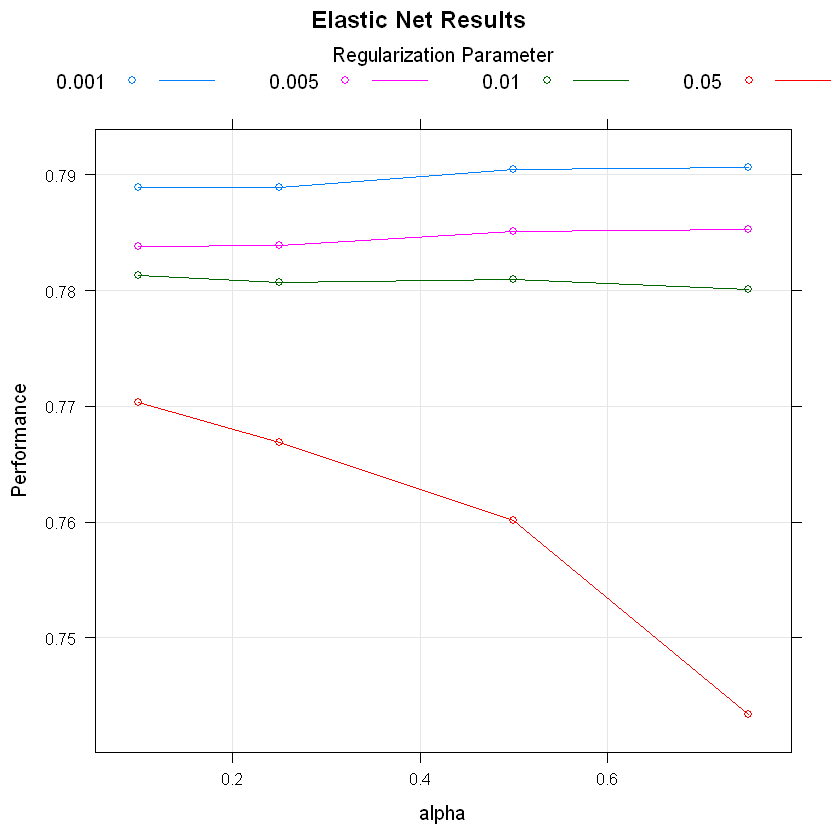

In [71]:
plot(elas_fit, xlab="alpha", ylab="Performance", main="Elastic Net Results" )

Alpha = 0.75 (highest), Lambda = 0.001 (lowest). Penalized low.

## Random Forest
Random Forest runs and results

In [27]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
rf_grid = expand.grid(splitrule=c("gini", "extratrees"), mtry = c(3, 6, 10, 20), min.node.size = 5)
set.seed(1)
rf_fit=train(gender ~ ., 
             data = train[, -c("unique_id")],
             method = "ranger",
             trControl = fitControl,
             metric = "perfo",
             tuneGrid = rf_grid)

In [28]:
rf_fit

Random Forest 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  splitrule   mtry  ROC        Sens       Spec       perfo    
  gini         3    0.8610332  0.7796699  0.8013327  0.8257672
  gini         6    0.8640422  0.8048928  0.7714262  0.8261008
  gini        10    0.8639790  0.8105482  0.7627611  0.8253168
  gini        20    0.8616785  0.8146225  0.7532691  0.8228122
  extratrees   3    0.8295563  0.7220987  0.7945153  0.7939316
  extratrees   6    0.8380733  0.7712952  0.7579104  0.8013380
  extratrees  10    0.8407754  0.7865166  0.7403723  0.8021099
  extratrees  20    0.8431684  0.7996727  0.7417189  0.8069321

Tuning parameter 'min.node.size' was held constant at a value of 5
perfo was used to select the optimal model using the largest value.
The

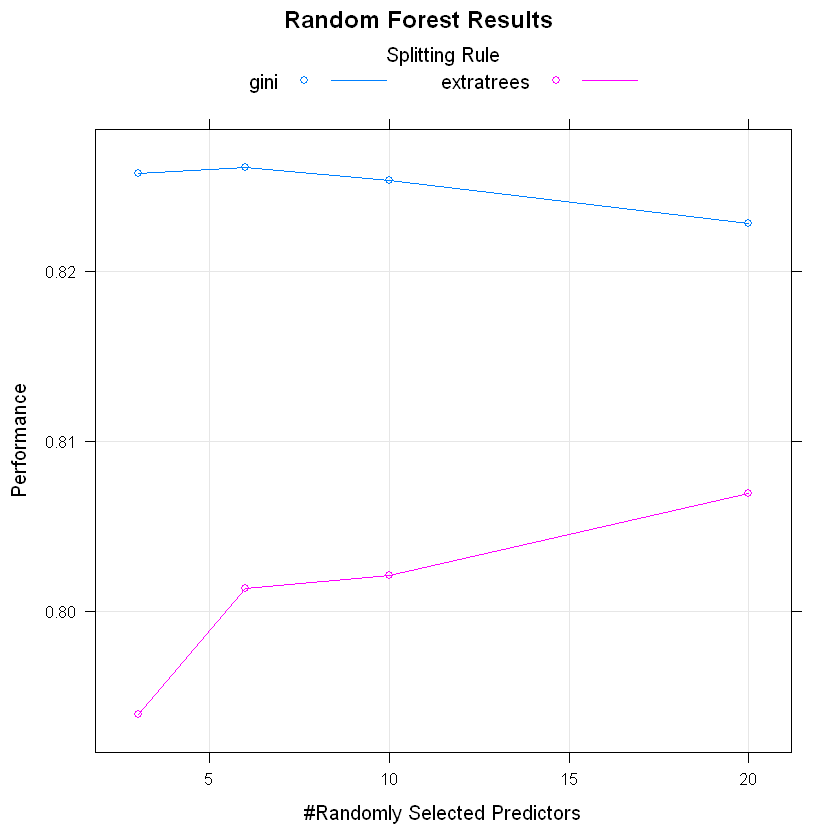

In [29]:
plot(rf_fit, ylab="Performance", main="Random Forest Results")

Gini split rule and 6 variables provided best results.

In [72]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
rf_grid = expand.grid(splitrule=c("gini"), mtry = c(3, 6), min.node.size = 5)
set.seed(1)
rf_fit_scaled=train(gender ~ ., 
             data = train_scaled[, -c("unique_id")],
             method = "ranger",
             trControl = fitControl,
             metric = "perfo",
             tuneGrid = rf_grid)

In [73]:
rf_fit_scaled

Random Forest 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec       perfo    
  3     0.8605532  0.7796684  0.8028813  0.8259140
  6     0.8641476  0.8036447  0.7710133  0.8257383

Tuning parameter 'splitrule' was held constant at a value of gini

Tuning parameter 'min.node.size' was held constant at a value of 5
perfo was used to select the optimal model using the largest value.
The final values used for the model were mtry = 3, splitrule = gini
 and min.node.size = 5.

Scaled train did not improve results

## SVM
Support Vector Machines runs adn results

In [74]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
svm_grid = expand.grid(C = c(0.25, 0.5, 1, 2), sigma = c(0.01, 0.02, 0.03))
set.seed(1)
svm_fit=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "svmRadial", 
              trControl = fitControl, 
              metric = c("perfo"),
              tuneGrid = svm_grid)

In [75]:
svm_fit

Support Vector Machines with Radial Basis Function Kernel 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  C     sigma  ROC        Sens       Spec       perfo    
  0.25  0.01   0.8043833  0.6119604  0.8686806  0.7723519
  0.25  0.02   0.8011738  0.6528412  0.8333011  0.7721225
  0.25  0.03   0.7927593  0.6682795  0.7934865  0.7618212
  0.50  0.01   0.8127793  0.6416957  0.8601191  0.7818434
  0.50  0.02   0.8061258  0.6734985  0.8098910  0.7739103
  0.50  0.03   0.7977999  0.6954081  0.7619256  0.7632334
  1.00  0.01   0.8171872  0.6630059  0.8375311  0.7837278
  1.00  0.02   0.8083625  0.6991583  0.7793515  0.7738087
  1.00  0.03   0.7972670  0.7190000  0.7298478  0.7608454
  2.00  0.01   0.8182423  0.6812719  0.8146317  0.7830970
  2.00  0.02   0.8063558

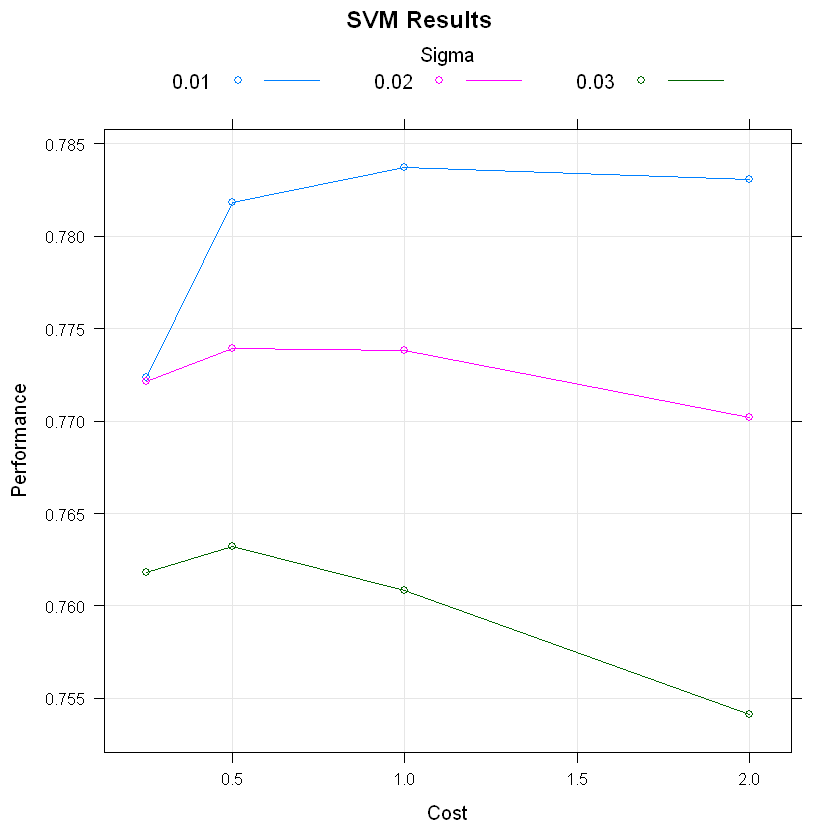

In [76]:
plot(svm_fit, ylab="Performance", main="SVM Results")

Best results are obtained with sigma = 0.01 and C = 1

## GBM
Runs and results for Gradient Boosting Machines

In [ ]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
gbmGrid=expand.grid(interaction.depth = c(4, 5, 6), 
                        n.trees = c(1:8)*50, 
                        shrinkage = c(0.025, 0.05),
                        n.minobsinnode = 10)
set.seed(1)
gbm_fit=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "gbm", 
              trControl = fitControl, 
              metric = c("perfo"),
              tuneGrid = gbmGrid)

In [78]:
gbm_fit

Stochastic Gradient Boosting 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  ROC        Sens       Spec     
  0.025      4                   50      0.8539974  0.7153560  0.8417734
  0.025      4                  100      0.8598394  0.7203576  0.8486854
  0.025      4                  150      0.8634057  0.7280768  0.8495096
  0.025      4                  200      0.8650514  0.7350366  0.8486838
  0.025      4                  250      0.8658942  0.7408533  0.8451760
  0.025      4                  300      0.8663220  0.7456923  0.8399151
  0.025      4                  350      0.8665607  0.7494429  0.8363047
  0.025      4                  400      0.8665634  0.7519436  0.8350692
  0.025      5                   5

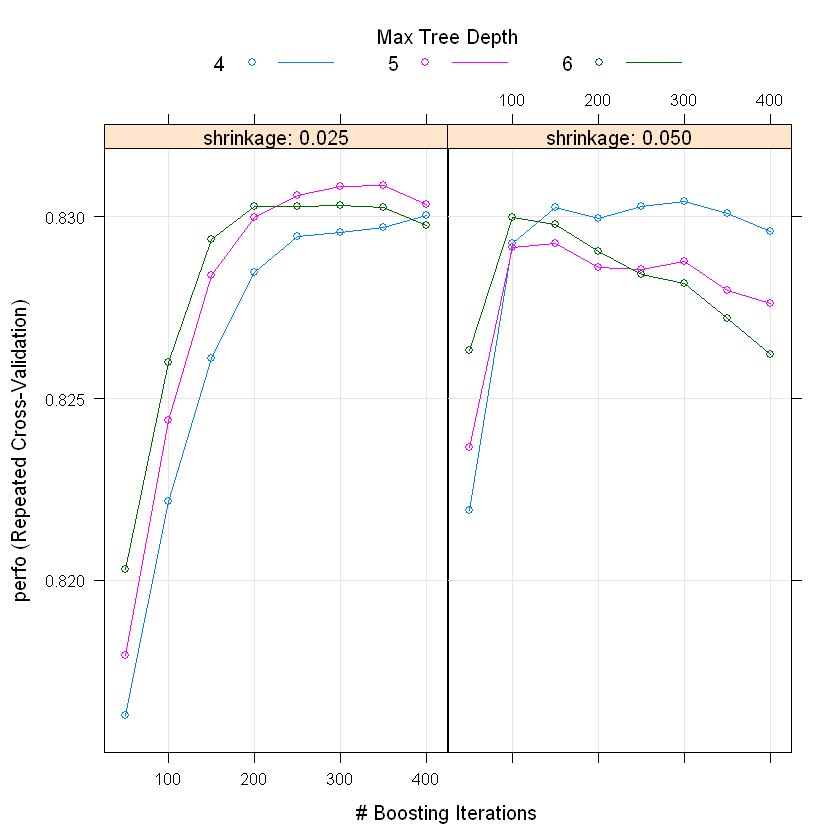

In [79]:
plot(gbm_fit)

In [ ]:
gbmGrid2=expand.grid(interaction.depth = c(4, 5, 6), 
                        n.trees = c(5:15)*100, 
                        shrinkage = c(0.01),
                        n.minobsinnode = 10)
set.seed(1)
gbm_fit2=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "gbm", 
              trControl = fitControl, 
              metric = c("perfo"),
              tuneGrid = gbmGrid2)

In [81]:
gbm_fit2

Stochastic Gradient Boosting 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  interaction.depth  n.trees  ROC        Sens       Spec       perfo    
  4                   500     0.8654553  0.7338939  0.8477544  0.8281397
  4                   600     0.8662505  0.7396019  0.8454831  0.8293965
  4                   700     0.8666813  0.7427005  0.8423898  0.8296132
  4                   800     0.8671119  0.7462349  0.8399172  0.8300940
  4                   900     0.8673181  0.7496598  0.8367197  0.8302539
  4                  1000     0.8673667  0.7522691  0.8355852  0.8306469
  4                  1100     0.8672889  0.7531936  0.8335233  0.8303237
  4                  1200     0.8672667  0.7548242  0.8319748  0.8303331
  4                  1300     0.86

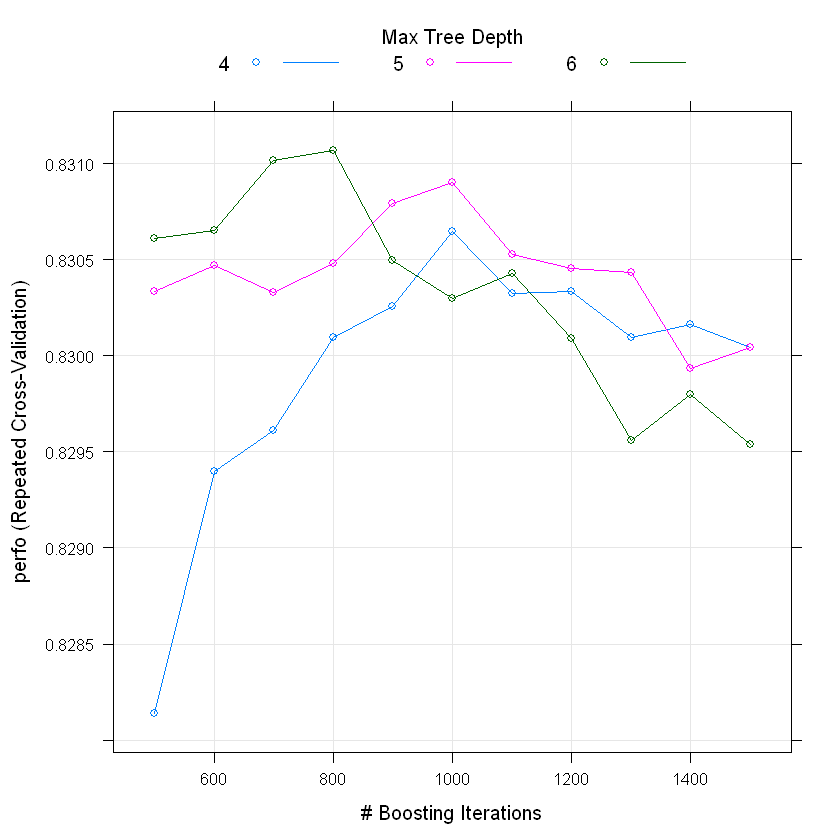

In [82]:
plot(gbm_fit2)

Best run is with learning rate 0.01, depth 6, ntree 600.

An old run below is preserved to be a reference fro parameter grids.

In [128]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        preProc = c("center", "scale", "nzv"),
                        sampling="up"
                       )
gbmGrid2=expand.grid(interaction.depth = c( 3, 4, 5, 6, 7), 
                        n.trees = c(1:20)*50, 
                        shrinkage = c(0.01, 0.025, 0.05, 0.1),
                        n.minobsinnode = 10)
set.seed(1)
gbm_fit_scaled_2=train(gender ~ ., 
                       data = train[, -c("unique_id")],
                       method = "gbm", 
                       trControl = fitControl, 
                       metric = c("perfo"),
                       tuneGrid = gbmGrid2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [129]:
gbm_fit_scaled_2

Stochastic Gradient Boosting 

5618 samples
  24 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  ROC        Sens       Spec     
  0.010      3                    50     0.8219434  0.6743130  0.8303146
  0.010      3                   100     0.8293355  0.6767055  0.8368143
  0.010      3                   150     0.8330622  0.6782276  0.8404241
  0.010      3                   200     0.8362224  0.6789347  0.8444469
  0.010      3                   250     0.8392935  0.6826860  0.8480594
  0.010      3                   300     0.8415976  0.6893730  0.8520816
  0.010      3                   350     0.8433697  0.6948630  0.8519780
  0.010      3                   400     0.8447271  0.6988320  0.8520816
  0.010      3                   4

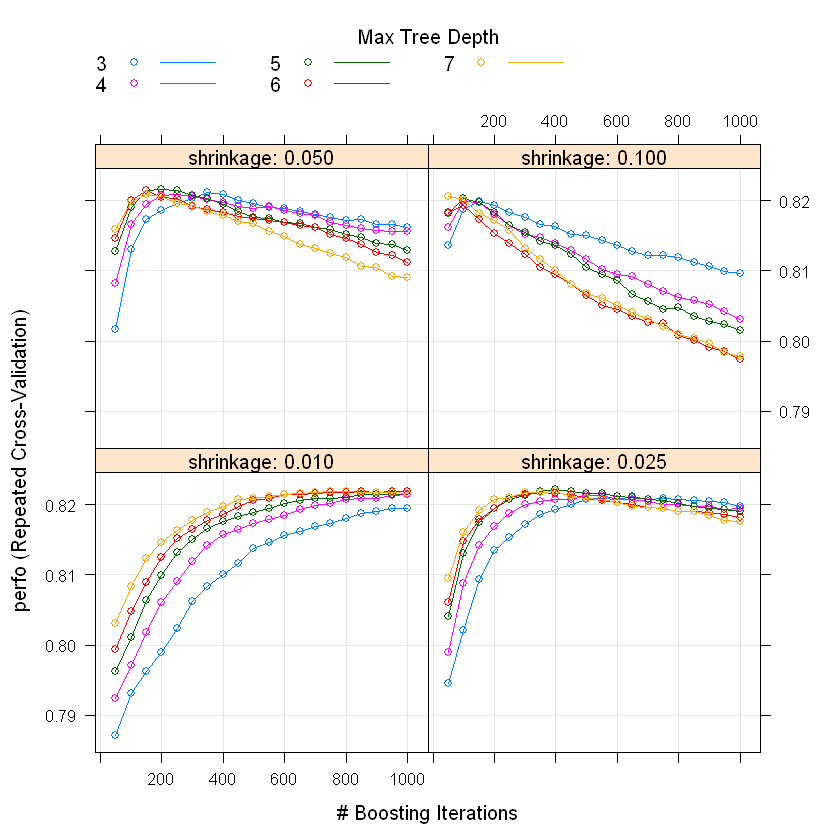

In [130]:
plot(gbm_fit_scaled_2)

## Ada Boost

In [99]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
ada_grid <- expand.grid(mfinal = (2:5)*3, maxdepth = c(3, 4),
                    coeflearn = c("Breiman", "Freund", "Zhu"))
set.seed(1)
ada_fit=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "AdaBoost.M1", 
              trControl = fitControl, 
              metric = c("perfo"),
              tuneGrid = ada_grid)

In [100]:
ada_fit

AdaBoost.M1 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  coeflearn  maxdepth  mfinal  ROC        Sens       Spec       perfo    
  Breiman    3          6      0.8474697  0.7139969  0.8400128  0.8122373
  Breiman    3          9      0.8519847  0.7187242  0.8382560  0.8152374
  Breiman    3         12      0.8544686  0.7241639  0.8359933  0.8172736
  Breiman    3         15      0.8553631  0.7269343  0.8342380  0.8179746
  Breiman    4          6      0.8473216  0.7337272  0.8287741  0.8142861
  Breiman    4          9      0.8519366  0.7407430  0.8241397  0.8171890
  Breiman    4         12      0.8539346  0.7428080  0.8252754  0.8189881
  Breiman    4         15      0.8548640  0.7445500  0.8235222  0.8194500
  Freund     3          6      0.8383171  

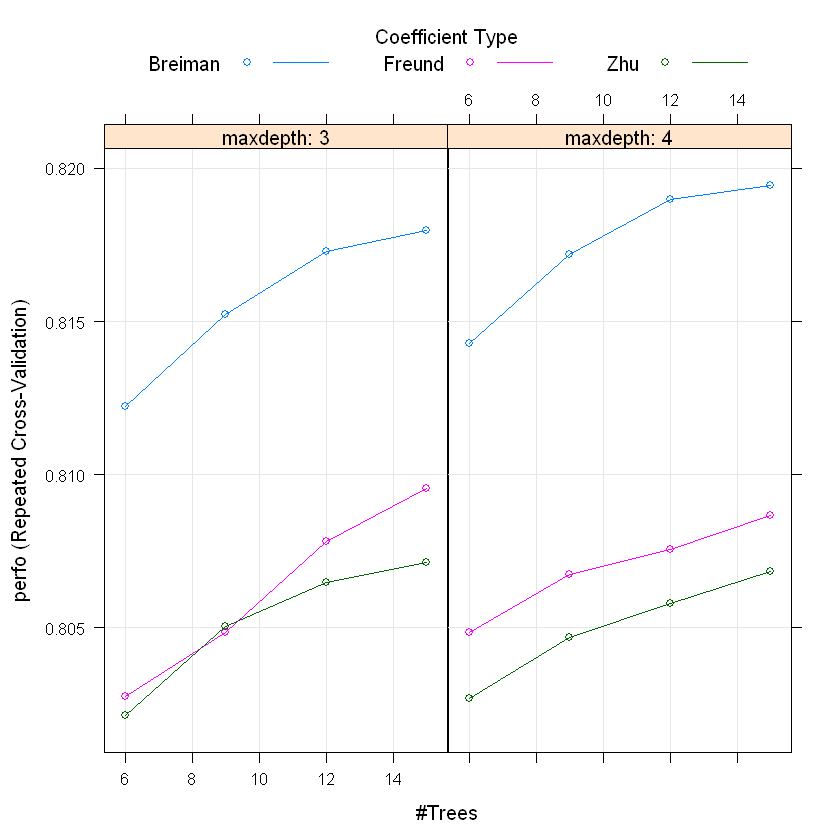

In [101]:
plot(ada_fit)

In [104]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
ada_grid2 <- expand.grid(mfinal = c(20, 30, 40), maxdepth = c(4, 5) ,
                    coeflearn = c("Breiman"))
set.seed(1)
ada_fit2=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "AdaBoost.M1", 
              trControl = fitControl, 
              metric = c("perfo"),
              tuneGrid = ada_grid2)

In [105]:
ada_fit2

AdaBoost.M1 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  maxdepth  mfinal  ROC        Sens       Spec       perfo    
  4         20      0.8556001  0.7459084  0.8247519  0.8204651
  4         30      0.8566316  0.7480293  0.8248539  0.8215366
  4         40      0.8570058  0.7471603  0.8288735  0.8225113
  5         20      0.8557244  0.7542794  0.8138251  0.8198883
  5         30      0.8564481  0.7559101  0.8124758  0.8203205
  5         40      0.8565791  0.7558570  0.8103109  0.8198315

Tuning parameter 'coeflearn' was held constant at a value of Breiman
perfo was used to select the optimal model using the largest value.
The final values used for the model were mfinal = 40, maxdepth = 4
 and coeflearn = Breiman.

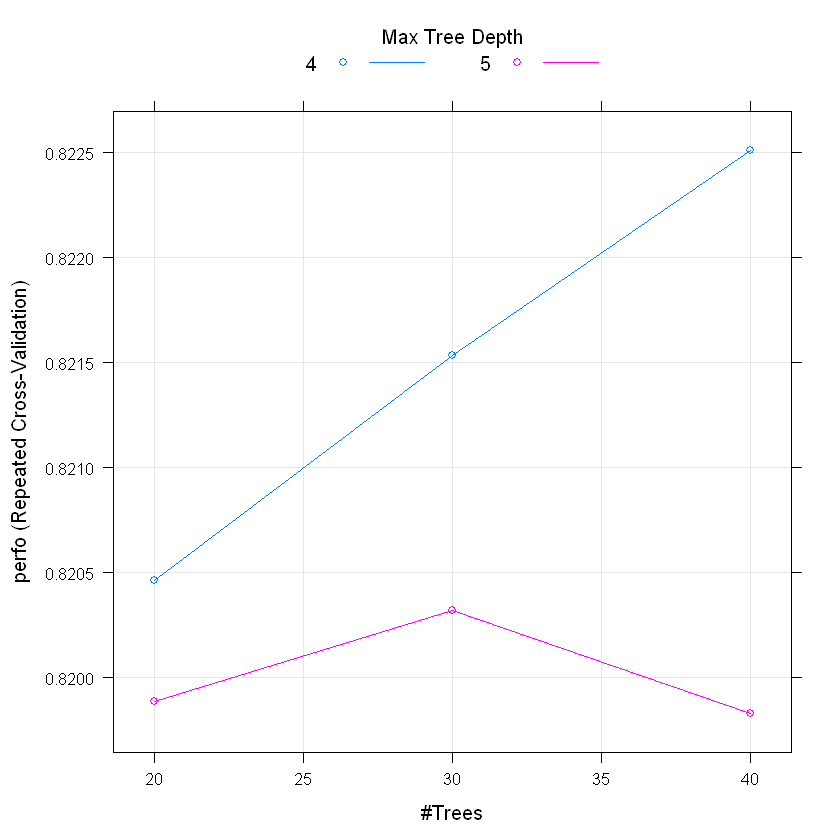

In [106]:
plot(ada_fit2)

In [110]:
n_repeats=5
n_folds=10
fitControl=trainControl(method = "repeatedcv",
                        number = n_folds,
                        repeats = n_repeats,
                        classProbs=TRUE, 
                        summaryFunction=performance,
                        sampling="up"
                       )
ada_grid3 <- expand.grid(mfinal = c(30, 40, 50, 60, 70, 80, 90, 100, 110, 120), maxdepth = c(4) ,
                    coeflearn = c("Breiman"))
set.seed(1)
ada_fit3=train(gender ~ ., 
              data = train[, -c("unique_id")],
              method = "AdaBoost.M1", 
              trControl = fitControl, 
              metric = c("perfo"),
              tuneGrid = ada_grid3)

In [111]:
ada_fit3

AdaBoost.M1 

5618 samples
  30 predictor
   2 classes: 'F', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5057, 5056, 5056, 5056, 5056, 5056, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mfinal  ROC        Sens       Spec       perfo    
   30     0.8572528  0.7492206  0.8206175  0.8210859
   40     0.8579510  0.7494386  0.8213413  0.8216704
   50     0.8581199  0.7506880  0.8221660  0.8222734
   60     0.8581310  0.7493850  0.8246440  0.8225728
   70     0.8583464  0.7493854  0.8254741  0.8228881
   80     0.8581283  0.7498205  0.8261909  0.8230670
   90     0.8584802  0.7506914  0.8246424  0.8230735
  100     0.8587718  0.7525934  0.8231975  0.8233336
  110     0.8588559  0.7538436  0.8204134  0.8229922
  120     0.8586762  0.7534637  0.8214454  0.8230654

Tuning parameter 'maxdepth' was held constant at a value of 4
Tuning
 parameter 'coeflearn' was held constant at a value of 

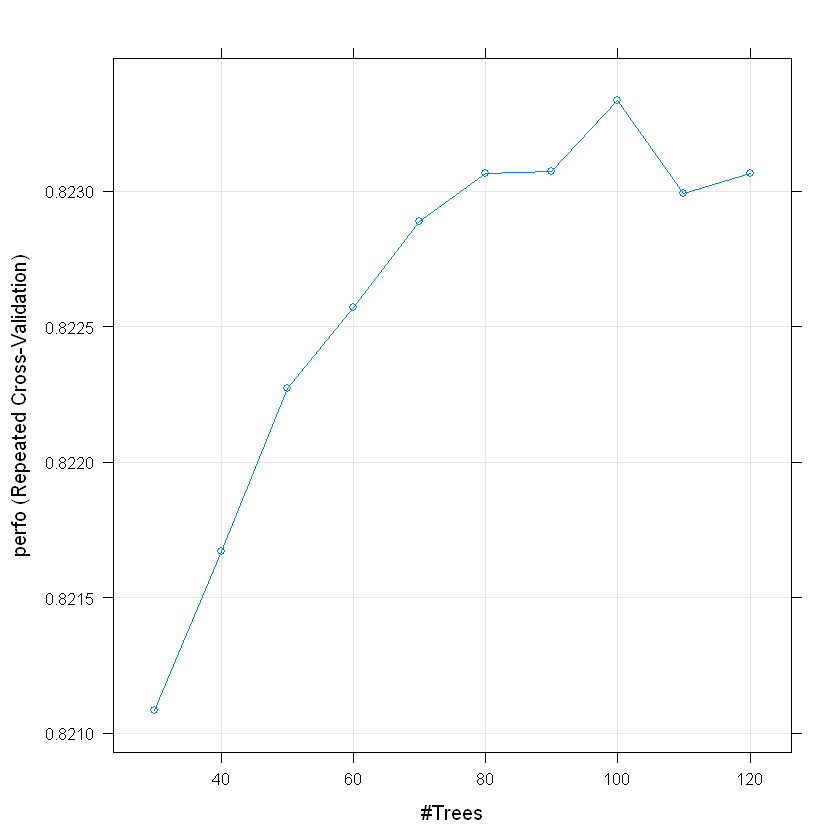

In [112]:
plot(ada_fit3)

The best model is the one with Breiman coef, 100 trees and 4 depth.

## Resample

In [113]:
resamps2 <- resamples(list(CART = cart_fit,
                           CART_scaled = cart_fit_scaled,
                           Lasso = lasso_fit,
                           Lasso_scaled = lasso_fit_scaled,                           
                           ElasticNet = elas_fit,
                           RF = rf_fit,
                           RF_scaled = rf_fit_scaled,
                           SVM = svm_fit,
                           GBM = gbm_fit,
                           GBM_2 = gbm_fit2,
                           ADA = ada_fit3
                          ))
summary(resamps2)


Call:
summary.resamples(object = resamps2)

Models: CART, CART_scaled, Lasso, Lasso_scaled, ElasticNet, RF, RF_scaled, SVM, GBM, GBM_2, ADA 
Number of resamples: 50 

perfo 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
CART         0.7501541 0.7898627 0.8074924 0.8028670 0.8133072 0.8375308    0
CART_scaled  0.7501541 0.7898627 0.8074924 0.8028557 0.8133072 0.8375308    0
Lasso        0.7540690 0.7821342 0.7907924 0.7920407 0.8033533 0.8267873    0
Lasso_scaled 0.7540690 0.7821342 0.7907924 0.7920407 0.8033533 0.8267873    0
ElasticNet   0.7562021 0.7805277 0.7875736 0.7906299 0.8011402 0.8296658    0
RF           0.7925714 0.8174340 0.8266192 0.8261008 0.8357755 0.8598688    0
RF_scaled    0.7873536 0.8186462 0.8275822 0.8259140 0.8334110 0.8551869    0
SVM          0.7470010 0.7741291 0.7826787 0.7837278 0.7920113 0.8178858    0
GBM          0.7963083 0.8228040 0.8298269 0.8308662 0.8397597 0.8632935    0
GBM_2        0.7906788 0.8215977 0.8290250 0.

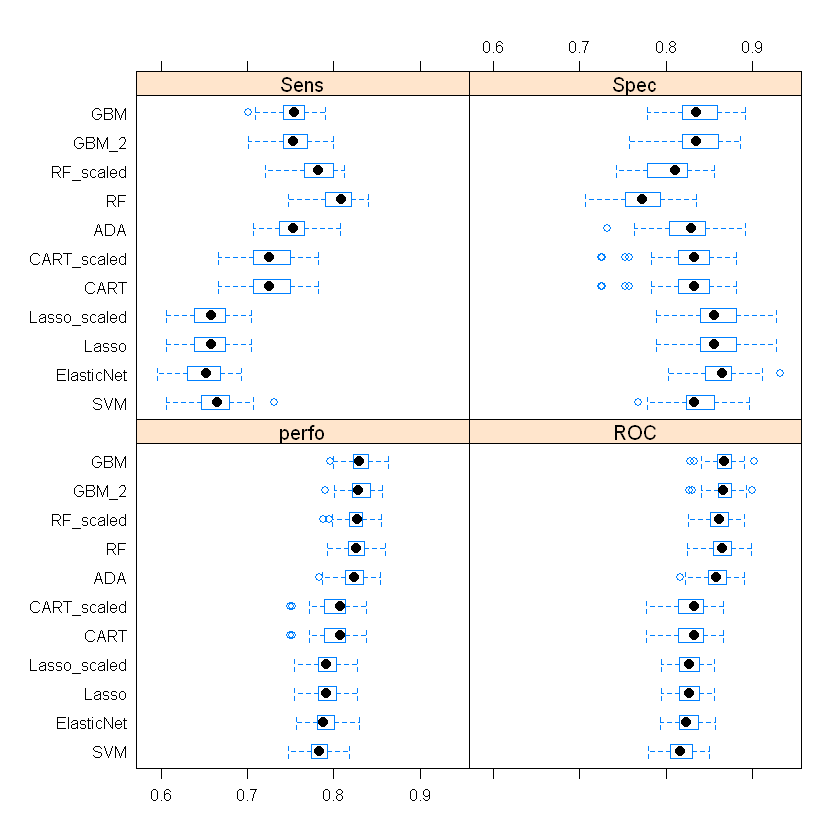

In [114]:
bwplot(resamps2)

Comparing results, we see taht GBM results are relatively better. Also comparing variances, GBM results are acceptable.

## Test
Using selected model, get predictions for test data

In [122]:
test = fread("test_feature.csv", encoding = "UTF-8")

In [123]:
cols_test = c('brand_gender', 'cat_gender', 'fav_product_gender', 'wDay_basket',
              'wDay_favorite', 'wDay_order', 'wDay_search', 'wDay_visit', 'daytime_basket',
              'daytime_favorite', 'daytime_order', 'daytime_search', 'daytime_visit')

In [124]:
test[,(cols_test):=lapply(.SD, as.factor),.SDcols=cols_test]

In [125]:
probs = round(predict(gbm_fit2, test[, -c("unique_id")], type="prob")[,"F"],3)

In [126]:
vectStr=paste(as.character(probs), sep="' '", collapse=",")
fileConn<-file("predictions/gbm_fit_v9.txt")
writeLines(vectStr, fileConn)
close(fileConn)

Token = 38b81b2c-d4ba-49fe-a9aa-79f884fd28c6